In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
COLORS = list(mcolors.TABLEAU_COLORS.values())
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, levene
import sys,os,re
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

---

# Problem Statement :
One of India's largest logistics company needs to understand and process the data coming out of data engineering pipelines. 
We need to clean, sanitize and manipulate data to get useful features out of raw fields.

# Insights :
- start_scan_to_end_scan has multiple peaks at ~0, 2000, 3000 implying that there are 3 major routes taken by the logisitcs the company
- actual_distance_to_destination also looks like the overlap of 3 poisson distributions (supporting above claim)
- actual_time, osrm_time and osrm_distance shows poisson like distribution
- segment_actual_time, segment_osrm_time and segment_osrm_distance seem to be possion distributed as well with an even lower lambda
- FTL has much higher actual_distance_to_destination and start_scan_to_end_scan than Carting
- The most busiest source cities are Bengaluru, Gurgaon (~4.5%)
- The most busiest source states are Maharashtra, Karnataka (~13%)
- The most busiest destination cities are Mumbai, Bengaluru (~4.5%)
- The most busiest destination states are Karnataka, Maharashtra (~13%)
- FTL transportation is slightly more than Carting (52%)
- t-test giving HIGH p-value means start_scan_to_end_scan and od_time_diff ARE NOT significantly different
- Welchs t-test giving LOW p-value means actual_time and osrm_time ARE significantly different
- t-test giving HIGH p-value means actual_time and segment_actual_time ARE NOT significantly different
- Welchs t-test giving LOW p-value means osrm_distance and segment_osrm_distance ARE significantly different
- Welchs t-test giving LOW p-value means osrm_time and segment_osrm_time ARE significantly different 

# Recommendations : 

# Loading Data

In [2]:
df = pd.read_csv('logistics_data.csv')

In [3]:
df.shape

(144867, 24)

In [4]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


## Non Visual EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

In [6]:
#Converting to datetime
for c in ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']:
    df[c] = pd.to_datetime(df[c])

In [7]:
#Null value treatment
df.isna().sum().sort_values(ascending=False).head()

source_name              293
destination_name         261
data                       0
cutoff_factor              0
segment_osrm_distance      0
dtype: int64

- source_name and destination_name have ~300 missing values each
- Lets drop these rows

In [8]:
df = df.dropna().reset_index(drop=True)

In [9]:
df.shape

(144316, 24)

In [10]:
df.describe()

,start_scan_to_end_scan,cutoff_factor,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
count,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000,144316.000000
mean,963.697698,233.561345,234.708498,417.996237,214.437055,285.549785,2.120178,36.175379,18.495697,22.818993,2.218707
std,1038.082976,345.245823,345.480571,598.940065,308.448543,421.717826,1.717065,53.524298,14.774008,17.866367,4.854804
min,20.000000,9.000000,9.000045,9.000000,6.000000,9.008200,0.144000,-244.000000,0.000000,0.000000,-23.444444
25%,161.000000,22.000000,23.352027,51.000000,27.000000,29.896250,1.604545,20.000000,11.000000,12.053975,1.347826
50%,451.000000,66.000000,66.135322,132.000000,64.000000,78.624400,1.857143,28.000000,17.000000,23.508300,1.684211
75%,1645.000000,286.000000,286.919294,516.000000,259.000000,346.305400,2.212280,40.000000,22.000000,27.813325,2.250000
max,7898.000000,1927.000000,1927.447705,4532.000000,1686.000000,2326.199100,77.387097,3051.000000,1611.000000,2191.403700,574.250000


In [11]:
df.describe(include='O')

,data,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name
count,144316,144316,144316,144316,144316,144316,144316,144316
unique,2,1497,2,14787,1496,1496,1466,1466
top,training,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,FTL,trip-153837029526866991,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana)
freq,104632,1812,99132,101,23267,23267,15192,15192


## Visual EDA

### Univariate

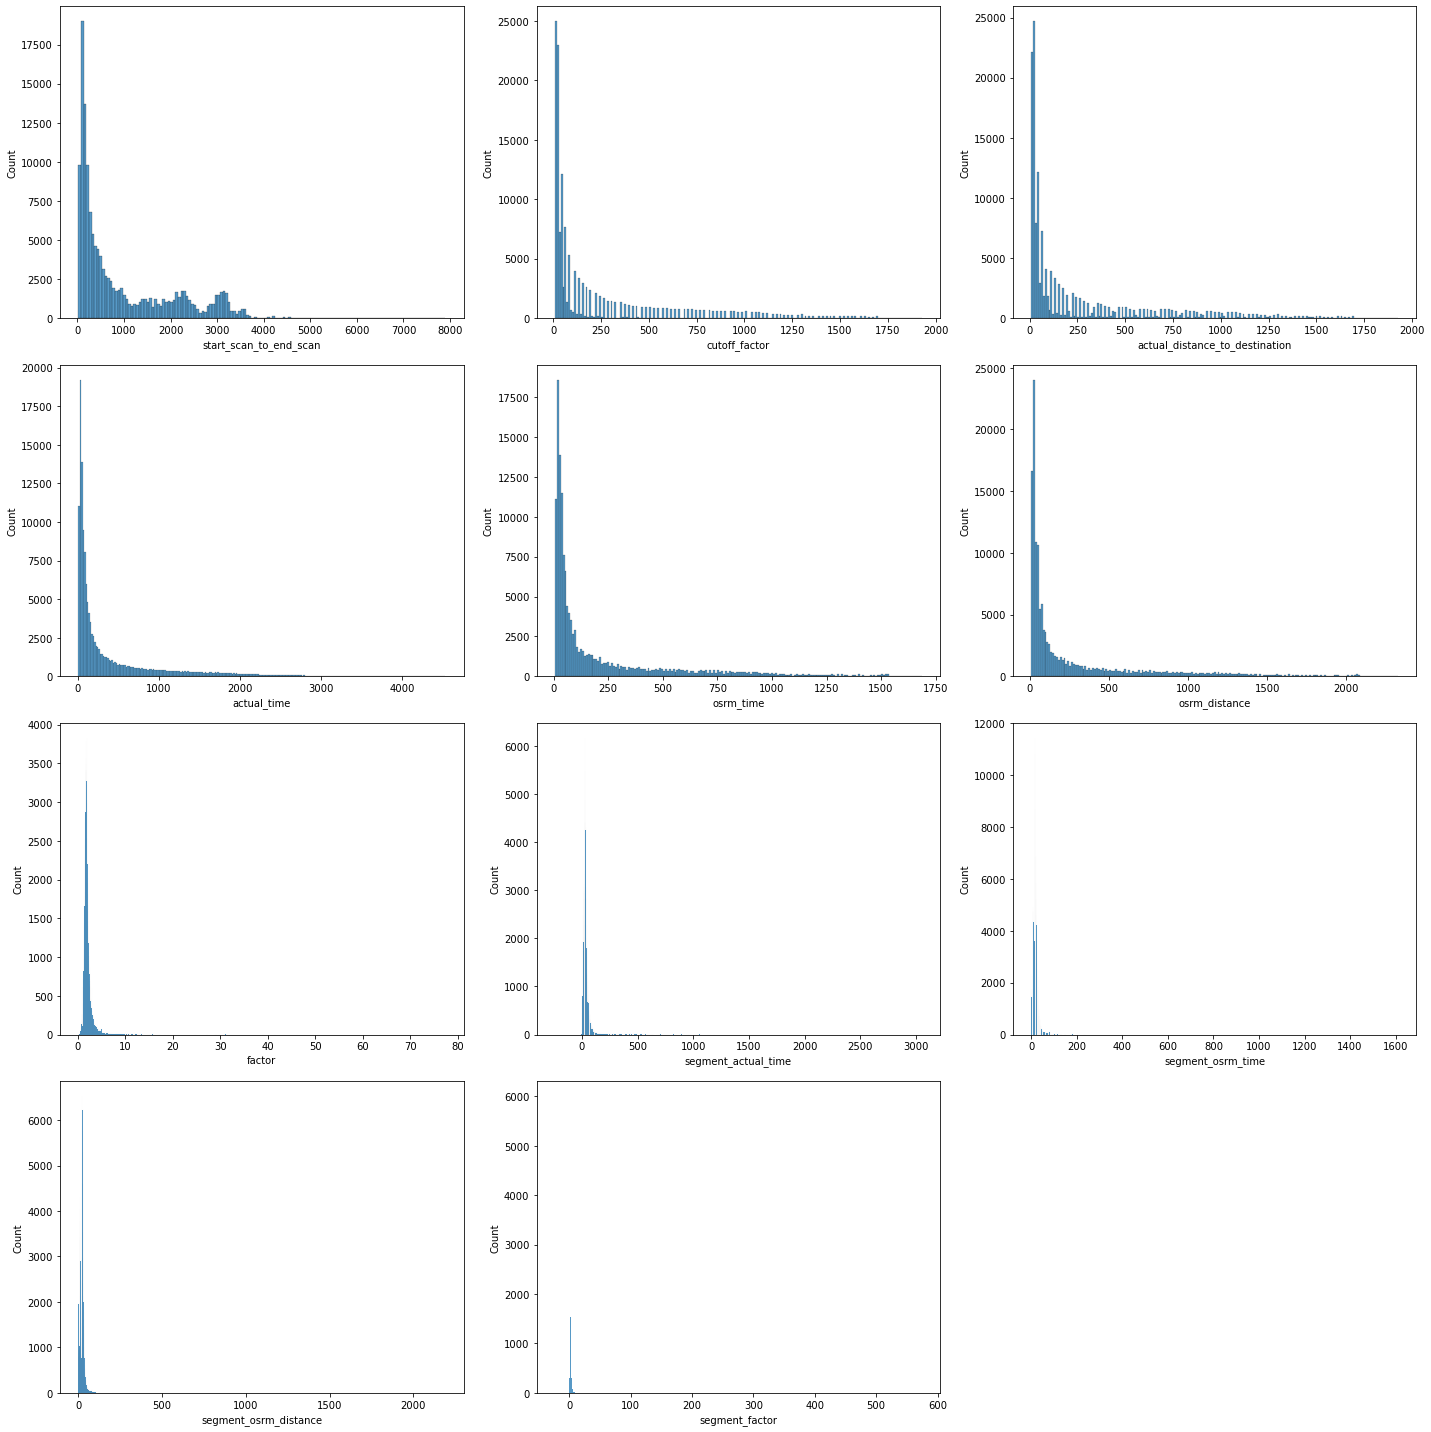

In [13]:
plt.rcParams['figure.figsize'] = 20,20
plt.rcParams['figure.autolayout'] = True
for e, c in enumerate(df.select_dtypes(include=['int','float']).columns):
    ax = plt.subplot(4,3,e+1)
    sns.histplot(df[c], ax=ax)

- start_scan_to_end_scan has multiple peaks at ~0, 2000, 3000 implying that there are 3 major routes taken by the logisitcs the company
- actual_distance_to_destination also looks like the overlap of 3 poisson distributions (supporting above claim)
- actual_time, osrm_time and osrm_distance shows poisson like distribution
- segment_actual_time, segment_osrm_time and segment_osrm_distance seem to be possion distributed as well with an even lower lambda

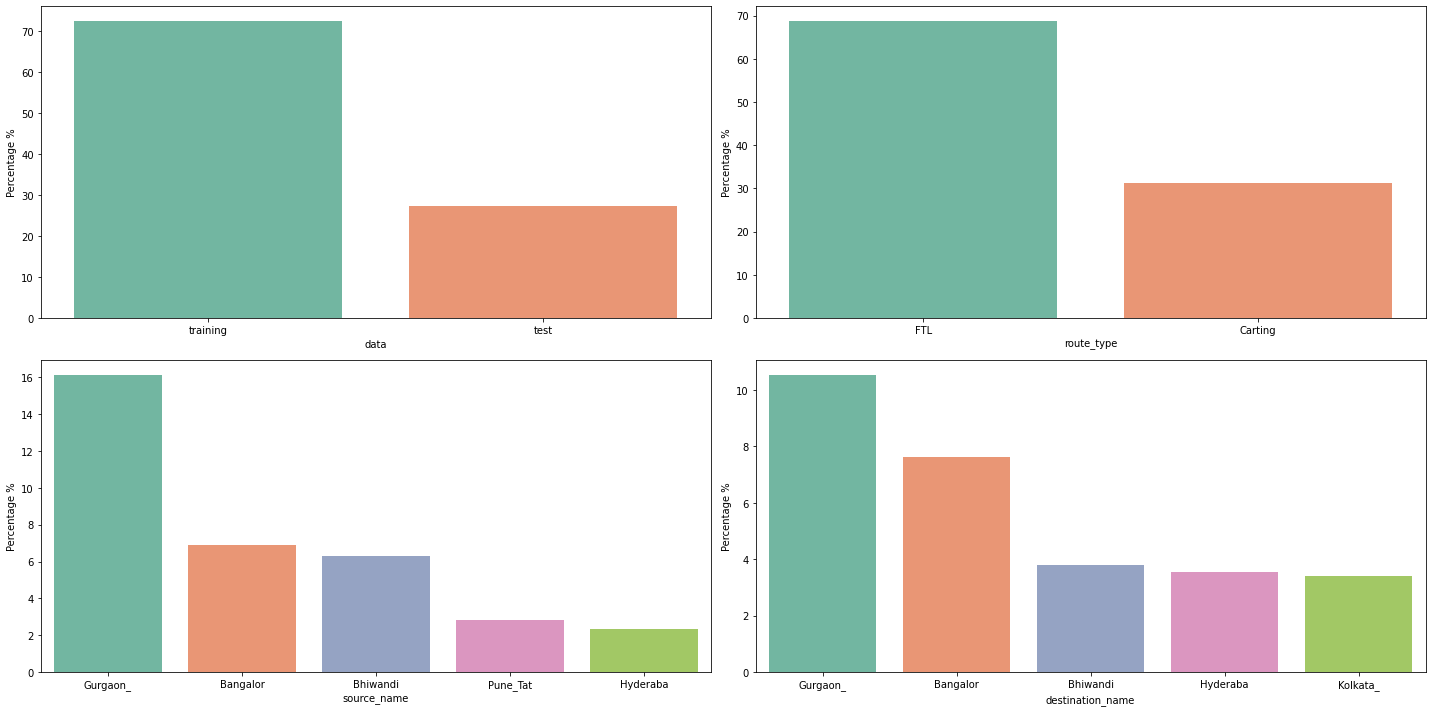

In [15]:
plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['figure.autolayout'] = True
for e, c in enumerate(['data', 'route_type', 'source_name', 'destination_name']):
    ax = plt.subplot(2,2,e+1)
    tmp = df[c].value_counts(1) * 100
    #show only top 5 categories
    if tmp.shape[0] > 5:
        tmp = tmp.head()
    tmp.index = [i[:8] for i in tmp.index]
    sns.barplot(x=tmp.index, y=tmp.values, ax=ax, palette='Set2')
    ax.set_ylabel('Percentage %')
    ax.set_xlabel(c)

- Training data ~70% 
- 65% of the route types are FTL
- Gurgaon is the busiest both in terms of source (15%) and destination (10%)

### Bivariate

<AxesSubplot:xlabel='route_type', ylabel='start_scan_to_end_scan'>

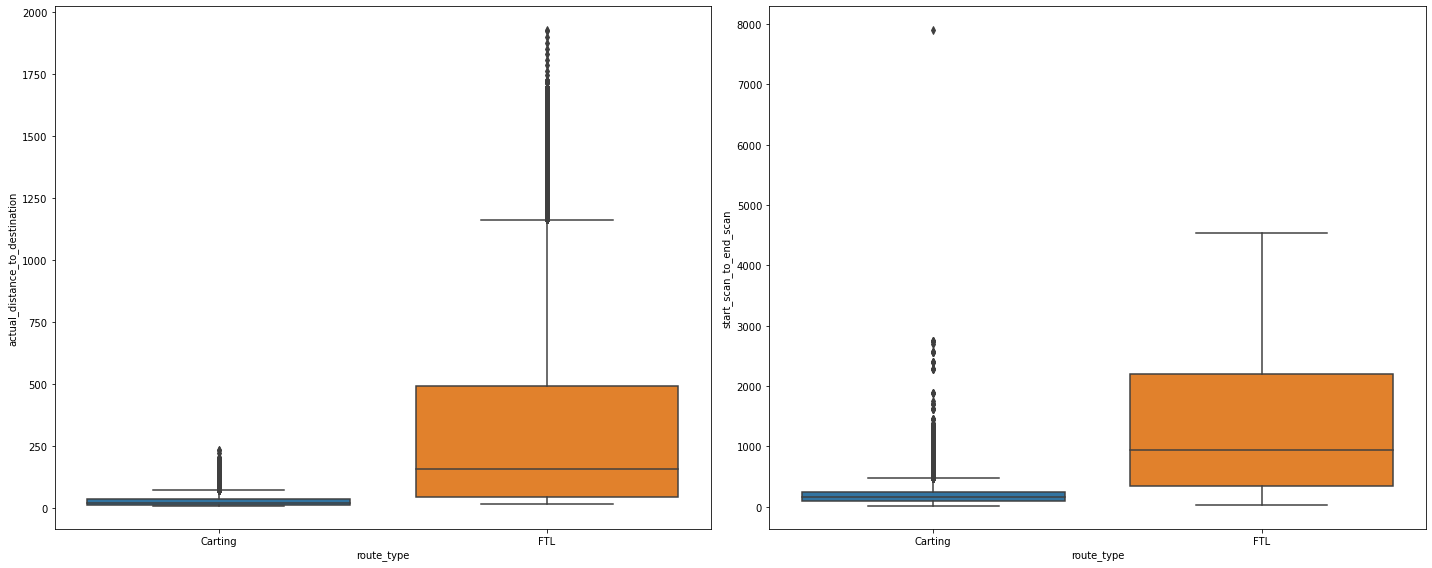

In [16]:
plt.rcParams['figure.figsize'] = 20,8
fig,ax = plt.subplots(1,2)
sns.boxplot(x='route_type',y='actual_distance_to_destination',data=df, ax=ax[0])
sns.boxplot(x='route_type',y='start_scan_to_end_scan',data=df, ax=ax[1])

- FTL has much higher actual_distance_to_destination and start_scan_to_end_scan than Carting

# Feature Engineering

In [12]:
#Calculating difference between od_end_time & od_start_time in minutes
od_time_diff = df['od_end_time'] - df['od_start_time']
df['od_time_diff'] = (od_time_diff.dt.days * 86400) + od_time_diff.dt.seconds
df['od_time_diff'] = df['od_time_diff']//60

In [13]:
#Extracting source and destination city
df['source_city'] = df['source_name'].apply(lambda x : re.findall('([a-z]+).*',x.lower())[0])
df['destination_city'] = df['destination_name'].apply(lambda x : re.findall('([a-z]+).*',x.lower())[0])

In [14]:
#Extracting source and destination state
df['source_state'] = df['source_name'].apply(lambda x : re.findall('.*\((.*)\)',x.lower())[0])
df['destination_state'] = df['destination_name'].apply(lambda x : re.findall('.*\((.*)\)',x.lower())[0])

In [15]:
#Extracting trip year, month and day
df['trip_creation_year'] = df['trip_creation_time'].dt.year
df['trip_creation_month'] = df['trip_creation_time'].dt.month
df['trip_creation_day'] = df['trip_creation_time'].dt.day

In [16]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,od_time_diff,source_city,destination_city,source_state,destination_state,trip_creation_year,trip_creation_month,trip_creation_day
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55.000000,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727,86,anand,khambhat,gujarat,gujarat,2018,9,20
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55.000000,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111,86,anand,khambhat,gujarat,gujarat,2018,9,20
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714,86,anand,khambhat,gujarat,gujarat,2018,9,20
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57.000000,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000,86,anand,khambhat,gujarat,gujarat,2018,9,20
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55.000000,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000,86,anand,khambhat,gujarat,gujarat,2018,9,20


---

# Data Aggregation

In [17]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,od_time_diff,source_city,destination_city,source_state,destination_state,trip_creation_year,trip_creation_month,trip_creation_day
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55.000000,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727,86,anand,khambhat,gujarat,gujarat,2018,9,20
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55.000000,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111,86,anand,khambhat,gujarat,gujarat,2018,9,20
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714,86,anand,khambhat,gujarat,gujarat,2018,9,20
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57.000000,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000,86,anand,khambhat,gujarat,gujarat,2018,9,20
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55.000000,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000,86,anand,khambhat,gujarat,gujarat,2018,9,20


In [18]:
df_trip_source_destination_level = df.groupby(['trip_uuid','source_center','destination_center']).agg(
                                    {'route_type':'first',
                                     'source_city':'first',
                                    'source_state':'first',
                                    'destination_city':'first',
                                    'destination_state':'first',
                                    'actual_time':'max',
                                    'osrm_time':'max',
                                    'segment_actual_time':'sum',
                                    'segment_osrm_time':'sum',
                                    'actual_distance_to_destination':'max',
                                    'osrm_distance':'max',
                                    'segment_osrm_distance':'sum',
                                    'start_scan_to_end_scan':'first',
                                    'od_time_diff':'first'})

In [19]:
df_trip_source_destination_level.shape

(26222, 14)

In [20]:
df_trip_source_destination_level.head()

route_type  \
trip_uuid               source_center destination_center              
trip-153671041653548748 IND209304AAA  IND000000ACB              FTL   
                        IND462022AAA  IND209304AAA              FTL   
trip-153671042288605164 IND561203AAB  IND562101AAA          Carting   
                        IND572101AAA  IND561203AAB          Carting   
trip-153671043369099517 IND000000ACB  IND160002AAC              FTL   

                                                         source_city  \
trip_uuid               source_center destination_center               
trip-153671041653548748 IND209304AAA  IND000000ACB            kanpur   
                        IND462022AAA  IND209304AAA            bhopal   
trip-153671042288605164 IND561203AAB  IND562101AAA        doddablpur   
                        IND572101AAA  IND561203AAB            tumkur   
trip-153671043369099517 IND000000ACB  IND160002AAC           gurgaon   

                                                            source_state  \
trip_uuid               source_center destination_center                   
trip-153671041653548748 IND209304AAA  IND000000ACB         uttar pradesh   
                        IND462022AAA  IND209304AAA        madhya pradesh   
trip-153671042288605164 IND561203AAB  IND562101AAA             karnataka   
                        IND572101AAA  IND561203AAB             karnataka   
trip-153671043369099517 IND000000ACB  IND160002AAC               haryana   

                                                         destination_city  \
trip_uuid               source_center destination_center                    
trip-153671041653548748 IND209304AAA  IND000000ACB                gurgaon   
                        IND462022AAA  IND209304AAA                 kanpur   
trip-153671042288605164 IND561203AAB  IND562101AAA             chikblapur   
                        IND572101AAA  IND561203AAB             doddablpur   
trip-153671043369099517 IND000000ACB  IND160002AAC             chandigarh   

                                                         destination_state  \
trip_uuid               source_center destination_center                     
trip-153671041653548748 IND209304AAA  IND000000ACB                 haryana   
                        IND462022AAA  IND209304AAA           uttar pradesh   
trip-153671042288605164 IND561203AAB  IND562101AAA               karnataka   
                        IND572101AAA  IND561203AAB               karnataka   
trip-153671043369099517 IND000000ACB  IND160002AAC                  punjab   

                                                          actual_time  \
trip_uuid               source_center destination_center                
trip-153671041653548748 IND209304AAA  IND000000ACB              732.0   
                        IND462022AAA  IND209304AAA              830.0   
trip-153671042288605164 IND561203AAB  IND562101AAA               47.0   
                        IND572101AAA  IND561203AAB               96.0   
trip-153671043369099517 IND000000ACB  IND160002AAC              611.0   

                                                          osrm_time  \
trip_uuid               source_center destination_center              
trip-153671041653548748 IND209304AAA  IND000000ACB            349.0   
                        IND462022AAA  IND209304AAA            394.0   
trip-153671042288605164 IND561203AAB  IND562101AAA             26.0   
                        IND572101AAA  IND561203AAB             42.0   
trip-153671043369099517 IND000000ACB  IND160002AAC            212.0   

                                                          segment_actual_time  \
trip_uuid               source_center destination_center                        
trip-153671041653548748 IND209304AAA  IND000000ACB                      728.0   
                        IND462022AAA  IND209304AAA                      820.0   
trip-153671042288605164 IND561203AAB  IND562101AAA                       46.0   
                   

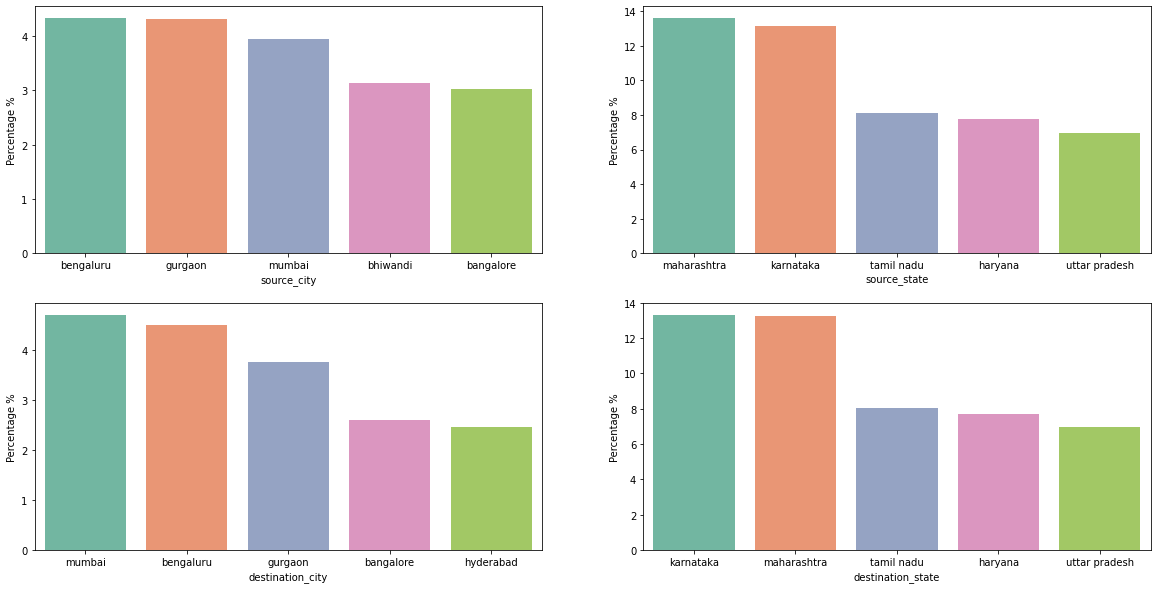

In [22]:
plt.rcParams['figure.figsize'] = 20,10
for e,c in enumerate(['source_city','source_state','destination_city','destination_state']):
    ax = plt.subplot(2,2,e+1)
    tmp = (df_trip_source_destination_level[c].value_counts(1) * 100).head()
    sns.barplot(x=tmp.index, y=tmp.values, ax=ax, palette='Set2')
    ax.set_xlabel(c)
    ax.set_ylabel("Percentage %")

- The most busiest source cities are Bengaluru, Gurgaon (~4.5%)
- The most busiest source states are Maharashtra, Karnataka (~13%)
- The most busiest destination cities are Mumbai, Bengaluru (~4.5%)
- The most busiest destination states are Karnataka, Maharashtra (~13%)
- FTL transportation is slightly more than Carting (52%)

In [23]:
df_trip_level = df_trip_source_destination_level.groupby('trip_uuid').agg({'route_type':'first',
                                                                            'actual_time':'sum',
                                                                            'osrm_time':'sum',
                                                                            'segment_actual_time':'sum',
                                                                            'segment_osrm_time':'sum',
                                                                            'actual_distance_to_destination':'sum',
                                                                            'osrm_distance':'sum',
                                                                            'segment_osrm_distance':'sum',
                                                                            'start_scan_to_end_scan':'sum',
                                                                            'od_time_diff':'sum'})
df_trip_level = df_trip_level.reset_index()

In [24]:
df_trip_level.shape

(14787, 11)

In [25]:
df_trip_level.head()

,trip_uuid,route_type,actual_time,osrm_time,segment_actual_time,segment_osrm_time,actual_distance_to_destination,osrm_distance,segment_osrm_distance,start_scan_to_end_scan,od_time_diff
0,trip-153671041653548748,FTL,1562.0,743.0,1548.0,1008.0,824.732854,991.3523,1320.4733,2259.0,2259
1,trip-153671042288605164,Carting,143.0,68.0,141.0,65.0,73.186911,85.1110,84.1894,180.0,180
2,trip-153671043369099517,FTL,3347.0,1741.0,3308.0,1941.0,1932.273969,2372.0852,2545.2678,3933.0,3933
3,trip-153671046011330457,Carting,59.0,15.0,59.0,16.0,17.175274,19.6800,19.8766,100.0,100
4,trip-153671052974046625,FTL,341.0,117.0,340.0,115.0,127.448500,146.7918,146.7919,717.0,717


## Comparing Distributions :  Hypothesis Testing / Visually

In [31]:
def compare_distributions(a, b):
    #Doing statistical Tests
    levene_pvalue = levene(a, b)[1]  #Running levene test to check equal variance assumption
    if levene_pvalue>0.05:
        #Equal Variance Assumption holds
        test_name = 't-test'
        ttest_ind_pvalue = ttest_ind(a, b, equal_var=True)[1]
    else:
        #Equal Variance Assumption does not hold
        test_name = 'Welchs t-test'
        ttest_ind_pvalue = ttest_ind(a, b, equal_var=False)[1]
        
    print(f'Levene Test p-value : {round(levene_pvalue*100, 2)} %')
    print(f'{test_name} p-value : {round(ttest_ind_pvalue*100, 2)} %')
    if ttest_ind_pvalue>0.05:
        print(f'{test_name} giving HIGH p-value means {a.name} and {b.name} ARE NOT significantly different')
    else:
        print(f'{test_name} giving LOW p-value means {a.name} and {b.name} ARE significantly different')
    
    #Doing visual analysis
    fig,ax = plt.subplots(1,1,figsize=(14,5))
    sns.histplot(x=a,color=COLORS[0], ax=ax, label=a.name, alpha=0.5)
    sns.histplot(x=b, color=COLORS[1], ax=ax, label=b.name, alpha=0.5)
    ax.legend()
    ax.set_xlabel(None)

### 1. start_scan_to_end_scan v od_time_diff

Levene Test p-value : 100.0 %
t-test p-value : 100.0 %
t-test giving HIGH p-value means start_scan_to_end_scan and od_time_diff ARE NOT significantly different


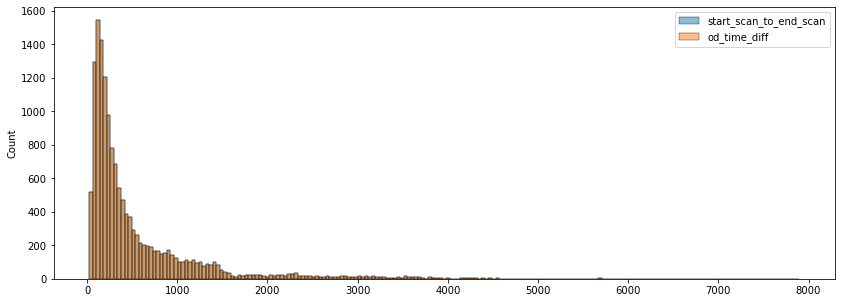

In [32]:
compare_distributions(df_trip_level['start_scan_to_end_scan'], df_trip_level['od_time_diff'])

### 2. actual_time v osrm_time

Levene Test p-value : 0.0 %
Welchs t-test p-value : 0.0 %
Welchs t-test giving LOW p-value means actual_time and osrm_time ARE significantly different


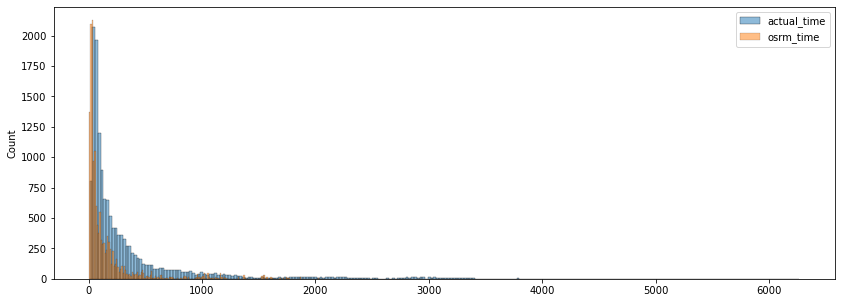

In [33]:
compare_distributions(df_trip_level['actual_time'], df_trip_level['osrm_time'])

### 3. actual_time v segment_actual_time

Levene Test p-value : 69.63 %
t-test p-value : 61.74 %
t-test giving HIGH p-value means actual_time and segment_actual_time ARE NOT significantly different


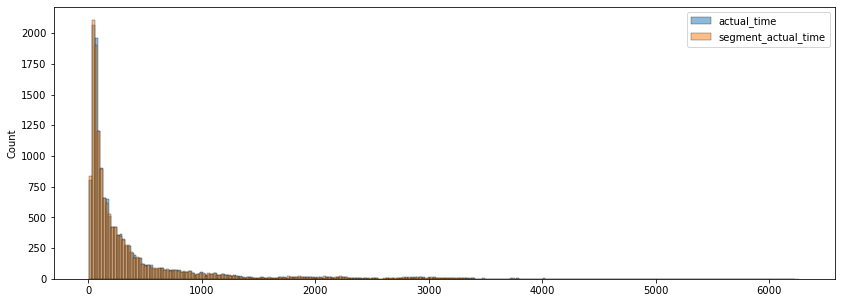

In [34]:
compare_distributions(df_trip_level['actual_time'], df_trip_level['segment_actual_time'])

### 4. osrm_distance v segment_osrm_distance

Levene Test p-value : 0.03 %
Welchs t-test p-value : 0.01 %
Welchs t-test giving LOW p-value means osrm_distance and segment_osrm_distance ARE significantly different


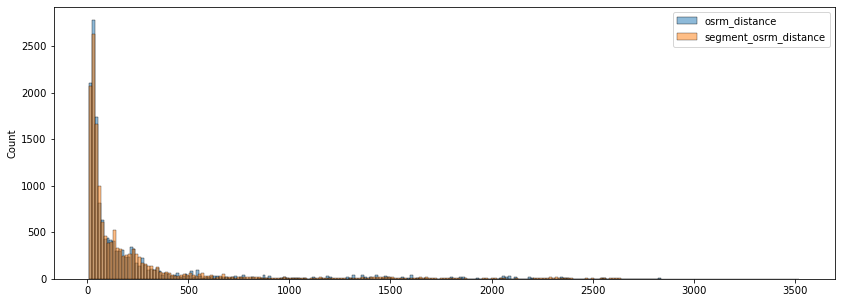

In [35]:
compare_distributions(df_trip_level['osrm_distance'], df_trip_level['segment_osrm_distance'])

### 5. osrm_time v segment_osrm_time

Levene Test p-value : 0.0 %
Welchs t-test p-value : 0.0 %
Welchs t-test giving LOW p-value means osrm_time and segment_osrm_time ARE significantly different


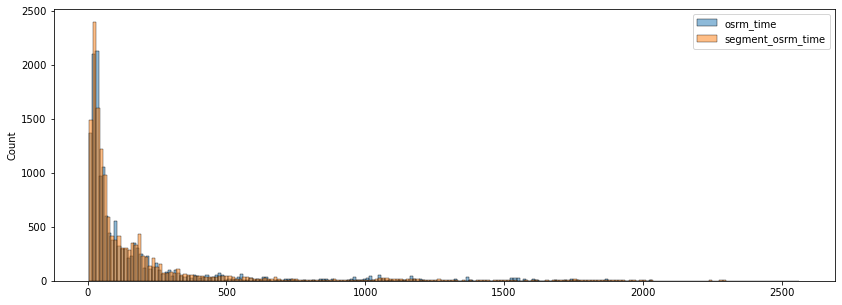

In [36]:
compare_distributions(df_trip_level['osrm_time'], df_trip_level['segment_osrm_time'])

# Outlier Treatment

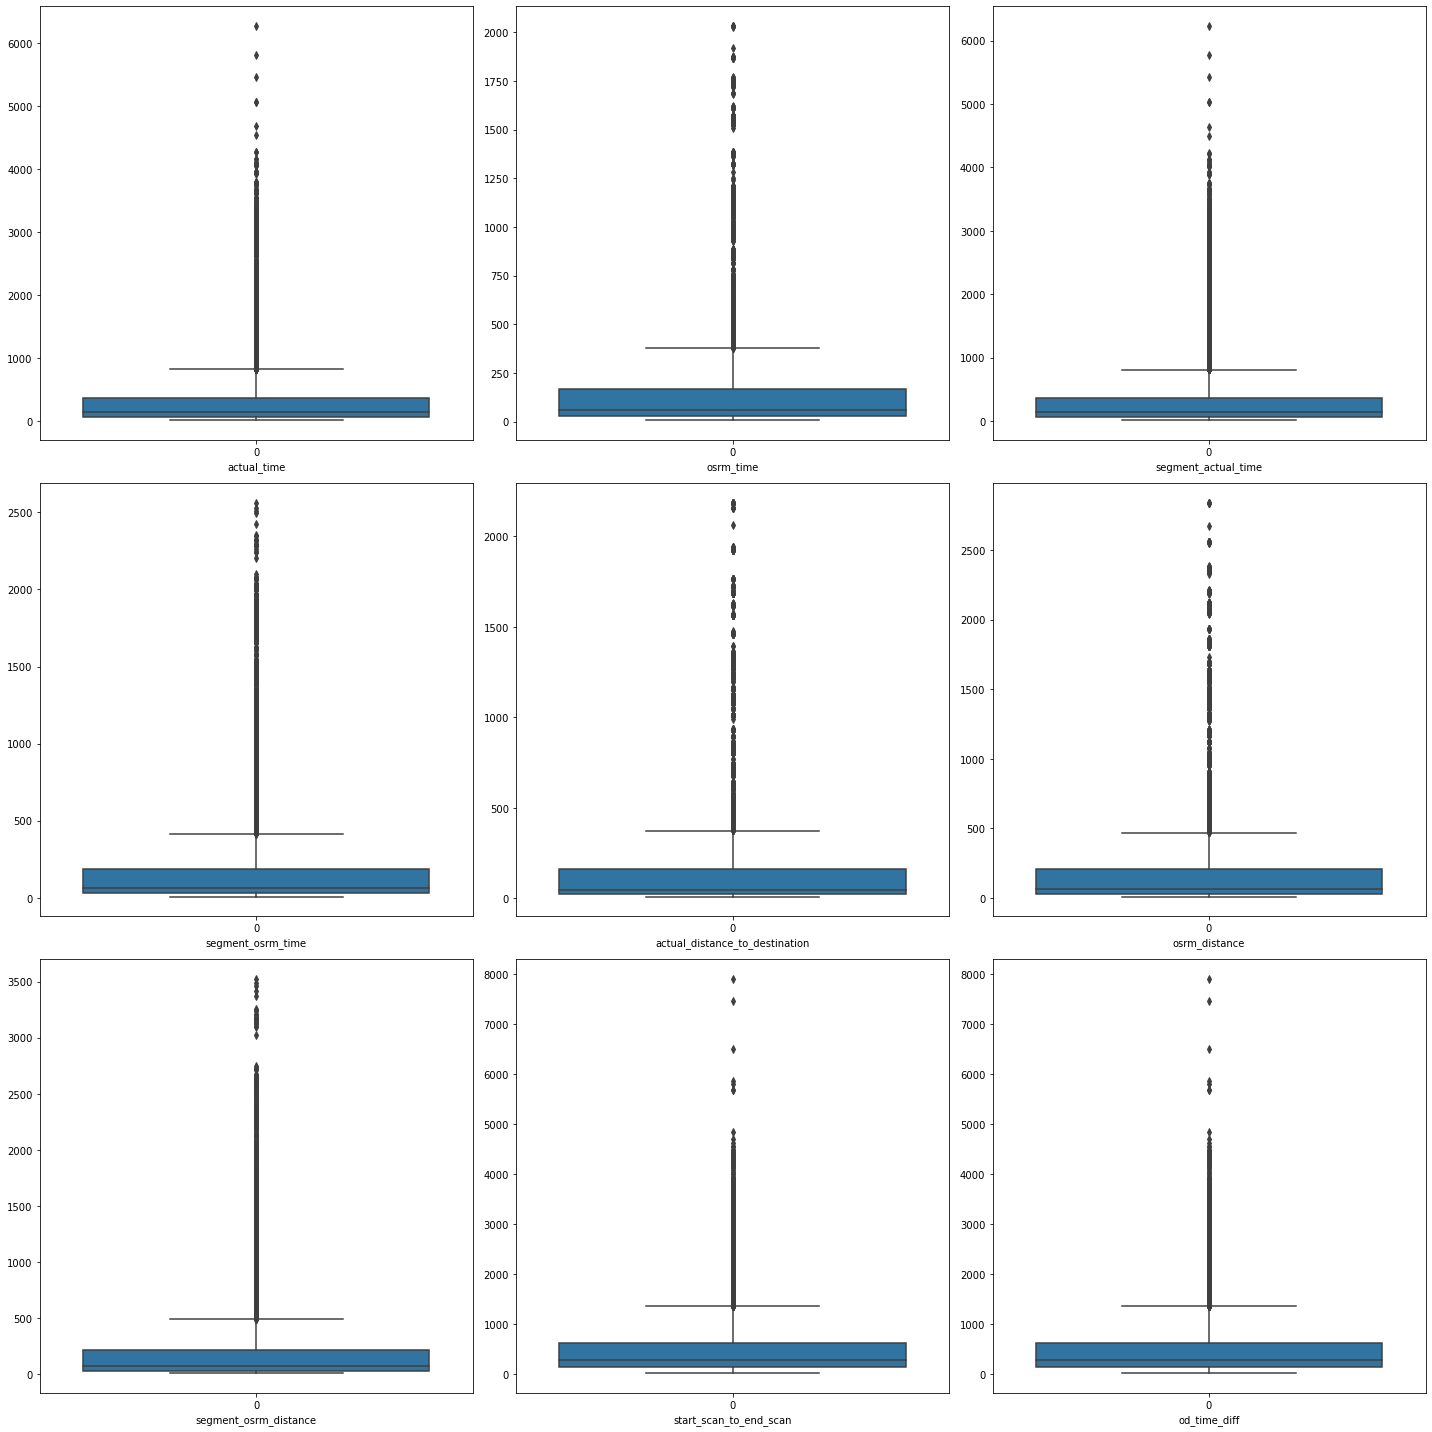

In [82]:
plt.rcParams['figure.figsize'] = 20,20
plt.rcParams['figure.autolayout'] = True
for e, c in enumerate(df_trip_level.select_dtypes(include=['int','float']).columns):
    ax = plt.subplot(3,3,e+1)
    sns.boxplot(data = df_trip_level[c], ax=ax)
    ax.set_xlabel(c)

- All the numeric features have a lot of outliers.

In [143]:
df_trip_level_no_outliers = df_trip_level.copy(deep=True)

In [144]:
df_trip_level_no_outliers.shape

(14787, 11)

In [145]:
def remove_outliers(df_):
    for c in df_.select_dtypes(include=['int','float']).columns:
        Q1 =  df_[c].quantile(0.25)
        Q3 =  df_[c].quantile(0.75)        
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5*IQR
        upper_whisker = Q3 + 1.5*IQR
        df_ = df_[(df_[c]>=lower_whisker) & (df_[c]<=upper_whisker)]
    return df_

In [146]:
df_trip_level_no_outliers = remove_outliers(df_trip_level_no_outliers).reset_index(drop=True)

In [147]:
df_trip_level_no_outliers.shape

(9163, 11)

----

# Encoding Categorical Features

In [148]:
ohe = OneHotEncoder(sparse=False)

In [153]:
ohe_data = pd.DataFrame(ohe.fit_transform(df_trip_level_no_outliers['route_type'].values.reshape(-1,1)), columns=ohe.get_feature_names())

C:\Users\rauna\Anaconda3\envs\scaler\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [156]:
ohe_data.head()

,x0_Carting,x0_FTL
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [154]:
df_trip_level_no_outliers = pd.concat([df_trip_level_no_outliers, ohe_data],axis=1)

In [157]:
df_trip_level_no_outliers['x0_Carting'].value_counts()

1.0    7780
0.0    1383
Name: x0_Carting, dtype: int64

----

# Scaling Numerical Features

In [167]:
mms = MinMaxScaler()

In [168]:
numerical_columns = ['actual_time', 'osrm_time', 'segment_actual_time', 
                     'segment_osrm_time','actual_distance_to_destination', 'osrm_distance',
                     'segment_osrm_distance', 'start_scan_to_end_scan', 'od_time_diff']

In [169]:
df_trip_level_no_outliers[numerical_columns] = mms.fit_transform(df_trip_level_no_outliers[numerical_columns])

In [172]:
df_trip_level_no_outliers.head()

,trip_uuid,route_type,actual_time,osrm_time,segment_actual_time,segment_osrm_time,actual_distance_to_destination,osrm_distance,segment_osrm_distance,start_scan_to_end_scan,od_time_diff,x0_Carting,x0_FTL
0,trip-153671042288605164,Carting,0.312354,0.290476,0.308411,0.277512,0.488537,0.476339,0.512384,0.342795,0.342795,1.0,0.0
1,trip-153671046011330457,Carting,0.116550,0.038095,0.116822,0.043062,0.062207,0.066448,0.073694,0.168122,0.168122,1.0,0.0
2,trip-153671055416136166,Carting,0.121212,0.076190,0.119159,0.076555,0.118698,0.118974,0.129547,0.362445,0.362445,1.0,0.0
3,trip-153671066201138152,Carting,0.034965,0.028571,0.035047,0.028708,0.000746,0.018452,0.020092,0.163755,0.163755,1.0,0.0
4,trip-153671066826362165,Carting,0.128205,0.128571,0.128505,0.129187,0.102159,0.124334,0.135383,0.268559,0.268559,1.0,0.0


----